In [1]:
import h5py
import pylab as pl
import numpy as np
import scipy.stats as sp
import matplotlib as mpl
import networkx

In [2]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [3]:
pl.rc('font', size = 20)
pl.rc('legend', fontsize = 20)
sim = h5py.File('/data/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/data/cielo/simulations/LG1/LG1_tree.dat')

In [4]:
Slist = h5py.File('SatelliteList_V2_withAngles_n500_KoK04.h5', 'r')
Satellites = Slist['SatelliteList'][()]
Centrals = Slist['SatelliteCentral'][()]

In [5]:
#ok, now the serialized version of the get particles for each Satellite, lets see.
TdayTotalIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][()] # need this first
I= np.identity(3) # and this

In [6]:
def getAllLastP(fofID, centralID):
    """
    get position, masses and abundances of all particles that in past snapshot belong to a given subhalo,
    and a z=0 are located at athe maximum distance of 600 kpc to the subhalo,
    rotated by the velocity and the vector to the centre.
    """
    uniqueID = int(128*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    #firts find all the particleIDs that once belong to the subgroup
    Idlist = []

    for mm in mtree[1:]: # ignore the first one
        snap, idd = split_unique_id(int(mm))
        tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        if tempOff[0]>= 0 and tempOff[1]>=0:
            tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
            Idlist.extend(list(tempIds))

    Idlist = np.array(Idlist)
    Idlist = np.unique(Idlist) # remove duplicates
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][fofID].astype('int')
    
    IndexToday = np.in1d(TdayTotalIDs, Idlist)
    IndexToday_ = np.where(IndexToday)[0]
    
    # lets remove the ones that are not part of the group today.
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    #now lets cut at  a certain distance
    #distance = 600 # distance in ckpc
    distance = 200 
    
#     mdistance = sim['SnapNumber_128/SubGroups/OpticalRadius'][centralID]*10.
    mdistance = 100
    
    posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][centralID]

    LostCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_]
    
    dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
    distToC = np.sqrt(dx**2+dy**2+dz**2)

    icut = np.where(distToC<distance)[0]
    IndexT_near = IndexT_[icut] # this is the almost final list of particles ids, but not yet
    
    LostCoord2 = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_near]
    
#     dx2, dy2, dz2 = LostCoord2[:,0]-posCen[0], LostCoord2[:,1]-posCen[1], LostCoord2[:,2]-posCen[2]
#     distToC2 = np.sqrt(dx2**2+dy2**2+dz2**2)

#     icut2 = np.where(distToC2>mdistance)[0]
#     IndexT_near_ = IndexT_near[icut2]
    
#     icut3 = np.where(distToC2<mdistance)[0]
#     IndexT_near_cutted = IndexT_near[icut3]


    LostNow = sim['SnapNumber_128/PartType0/SubGroupNumber'][IndexT_near]
    
    icut2 = np.where(LostNow==-1)[0]
    IndexT_near_ = IndexT_near[icut2]
    
    icut3 = np.where(LostNow!=-1)[0]
    IndexT_near_cutted = IndexT_near[icut3]
    
    # ok, lest see velocity and stuff
    velCen = sim['SnapNumber_128/SubGroups/SubGroupVel'][centralID]
    velSat = sim['SnapNumber_128/SubGroups/SubGroupVel'][fofID]

    velRep = velSat - velCen
    
    GasMasses = sim['SnapNumber_128/PartType0/Masses'][IndexT_near_]
    GassAbundances = sim['SnapNumber_128/PartType0/Abundances'][IndexT_near_]
    
    NearCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_near_]

    NearCoord_cutted = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_near_cutted]
    
    # first lets re-define coordinates in a galactocentric scheme.
    X, Y, Z = NearCoord[:,0] - posGal[0], NearCoord[:,1] - posGal[1], NearCoord[:,2] - posGal[2]
    xC, yC, zC = posCen[0] - posGal[0], posCen[1] - posGal[1], posCen[2] - posGal[2] # the direction of the centre from the galaxy
    
    XC, YC, ZC = NearCoord_cutted[:,0] - posGal[0], NearCoord_cutted[:,1] - posGal[1], NearCoord_cutted[:,2] - posGal[2]
    
    # now define normalized vectors, for velocity and centre directions
    velX, velY, velZ = velRep[0], velRep[1], velRep[2]
    Vel = np.sqrt(velX**2 + velY**2 + velZ**2)
    Cen = np.sqrt(xC**2 + yC**2 + zC**2)

    velx, vely, velz = velX/Vel, velY/Vel, velZ/Vel
    xc, yc, zc = xC/Cen, yC/Cen, zC/Cen
    
    # Then, the rotations matrix are, for velocity
    faV = (1-velx)/(vely**2+ velz**2)
    VV = np.array([[0, vely, velz], [-vely, 0, 0], [-velz, 0, 0]])
    VV2 = np.matmul(VV, VV)

    RV = I + VV + VV2*faV
    
    # and for the direction to the centre
    faC = (1-xc)/(yc**2+zc**2)
    CC = np.array([[0, yc, zc], [-yc, 0, 0], [-zc, 0, 0]])
    CC2 = np.matmul(CC, CC)

    RC = I + CC + CC2*faC
    
    # lets calculate the rotated coordinates
    xRv, yRv, zRv = [], [], []
    xRc, yRc, zRc = [], [], []

    for x, y, z in zip(X, Y, Z):
        dV = np.matmul(RV, np.array([x, y, z]))
        dC = np.matmul(RC, np.array([x, y, z]))
    
        xRv.append(dV[0])
        yRv.append(dV[1])
        zRv.append(dV[2])
    
        xRc.append(dC[0])
        yRc.append(dC[1])
        zRc.append(dC[2])
        
    
    xRv, yRv, zRv = np.array(xRv), np.array(yRv), np.array(zRv)
    xRc, yRc, zRc = np.array(xRc), np.array(yRc), np.array(zRc)
    
    xCv, yCv, zCv = [], [], []
    xCc, yCc, zCc = [], [], []
    
    for x, y, z in zip(XC, YC, ZC):
        dV = np.matmul(RV, np.array([x, y, z]))
        dC = np.matmul(RC, np.array([x, y, z]))
    
        xCv.append(dV[0])
        yCv.append(dV[1])
        zCv.append(dV[2])
    
        xCc.append(dC[0])
        yCc.append(dC[1])
        zCc.append(dC[2])
        
    xCv, yCv, zCv = np.array(xCv), np.array(yCv), np.array(zCv)
    xCc, yCc, zCc = np.array(xCc), np.array(yCc), np.array(zCc)
    
    datoff = np.array([fofID]*IndexT_near_cutted.size)
    
    # and return the 2 sets of rotated positions, masses and abundances
    return xRv, yRv, zRv, xRc, yRc, zRc, GasMasses, GassAbundances, xCv, yCv, zCv, xCc, yCc, zCc, datoff

In [7]:
# ok, lets try if this works before apply some serialized use.
xRv, yRv, zRv, xRc, yRc, zRc, GasMasses, GassAbundances, xCv, yCv, zCv, xCc, yCc, zCc, datoff = getAllLastP(4338, 4337)
print(xRv.size)

5319


In [8]:
import ipyvolume as ipv

ipv.figure(width=750, height=750)

ipv.scatter(xRv, yRv, zRv, marker='sphere', size=.1)

ipv.show()

In [9]:
import ipyvolume as ipv

ipv.figure(width=750, height=750)

ipv.scatter(xRc, yRc, zRc, marker='sphere', size=.1)

ipv.show()

Text(0, 0.5, 'z/(ckpc h^{-1})')

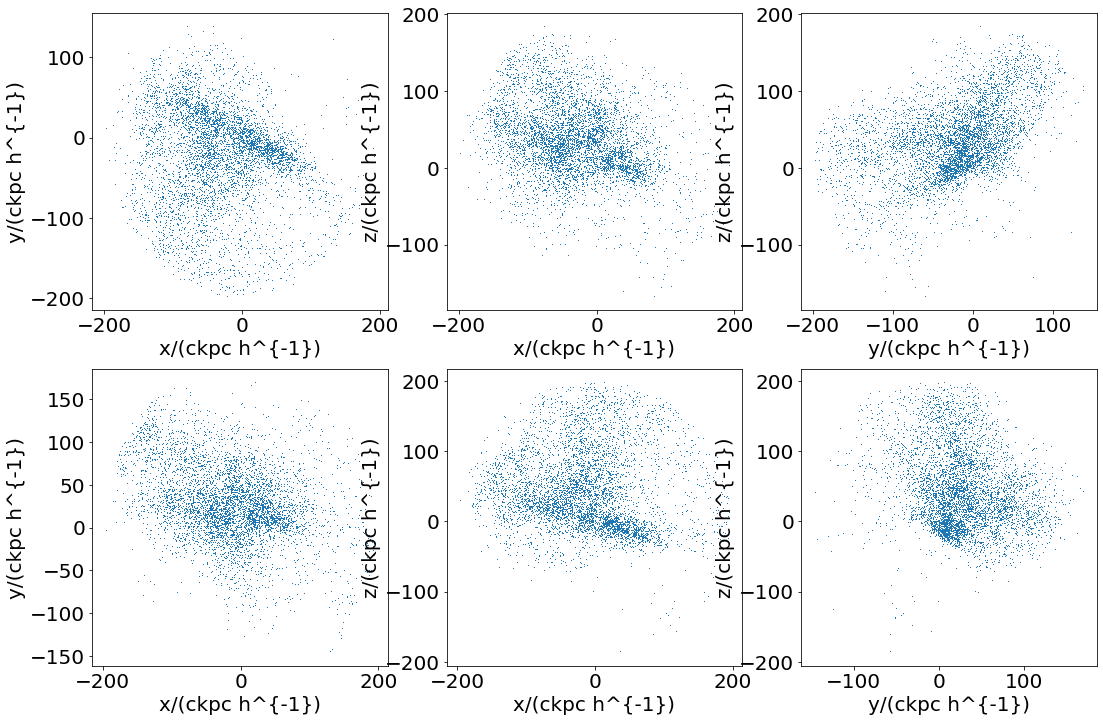

In [10]:
mark = ','
pl.figure(figsize=(18, 12))

pl.subplot(2, 3, 1)

pl.plot(xRv, yRv, marker=mark, ls='')
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')
#pl.arrow(0, 0, newV[0], newV[1], color='black', width=5)

pl.subplot(2, 3, 2)

pl.plot(xRv, zRv, marker=mark, ls='')
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')
#pl.arrow(0, 0, newV[0], newV[2], color='black', width=5)

pl.subplot(2, 3, 3)

pl.plot(yRv, zRv, marker=mark, ls='')
pl.xlabel('y/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')
#pl.arrow(0, 0, newV[1], newV[2], color='black', width=5)

pl.subplot(2, 3, 4)

pl.plot(xRc, yRc, marker=mark, ls='')
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')
#pl.arrow(0, 0, newC[0], newC[1], color='black', width=5)

pl.subplot(2, 3, 5)

pl.plot(xRc, zRc, marker=mark, ls='')
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')
#pl.arrow(0, 0, newC[0], newC[2], color='black', width=5)

pl.subplot(2, 3, 6)

pl.plot(yRc, zRc, marker=mark, ls='')
pl.xlabel('y/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')
#pl.arrow(0, 0, newC[1], newC[2], color='black', width=5)

In [11]:
# and it works, lets take a look at all at the same time
import progressbar

In [12]:
R200, GalCen, GroCen = [], [], []

for ss, cc in zip(Satellites, Centrals):
    group = sim['SnapNumber_128/SubGroups/GroupNumber'][cc]
    r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]
    galCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][ss]
    groCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][cc]
    
    R200.append(r200)
    GalCen.append(galCen)
    GroCen.append(groCen)

R200, GalCen, GroCen = np.array(R200), np.array(GalCen), np.array(GroCen)

sep = GalCen - GroCen
dist = np.sqrt(sep[:,0]**2+sep[:,1]**2+sep[:,2]**2)
dist = dist/R200

ir = np.where(dist>0.5)

Satellites = Satellites[ir]
Centrals = Centrals[ir]

Satellites.size

8

In [13]:
size = Satellites.size
# size = 100

bar = progressbar.ProgressBar(max_value=size)
C, passs = 0, 0

XRv, YRv, ZRv, XRc, YRc, ZRc, GASMasses, GASAbundances = [], [], [], [], [], [], [], []
XCv, YCv, ZCv, XCc, YCc, ZCc, DATAoff = [], [], [], [], [], [], []

for ff, cc in zip(Satellites, Centrals):
    try:
        xRv, yRv, zRv, xRc, yRc, zRc, GasMasses, GasAbundances, xCv, yCv, zCv, xCc, yCc, zCc, datoff = getAllLastP(ff, cc)
        passs += 1
    except:
        C += 1
        continue
    XRv.extend(list(xRv))
    YRv.extend(list(yRv))
    ZRv.extend(list(zRv))
    XRc.extend(list(xRc))
    YRc.extend(list(yRc))
    ZRc.extend(list(zRc))
    GASMasses.extend(list(GasMasses))
    GASAbundances.extend(list(GasAbundances))
    
    XCv.extend(list(xCv))
    YCv.extend(list(yCv))
    ZCv.extend(list(zCv))
    XCc.extend(list(xCc))
    YCc.extend(list(yCc))
    ZCc.extend(list(zCc))
    DATAoff.extend(list(datoff))
    
    C += 1
    bar.update(C)
    
XRv, YRv, ZRv, XRc, YRc, ZRc, GASMasses, GASAbundances = np.array(XRv), np.array(YRv), np.array(ZRv), np.array(XRc), np.array(YRc), np.array(ZRc), np.array(GASMasses), np.array(GASAbundances)
XCv, YCv, ZCv, XCc, YCc, ZCc, DATAoff = np.array(XCv), np.array(YCv), np.array(ZCv), np.array(XCc), np.array(YCc), np.array(ZCc), np.array(DATAoff)
passs

100% (8 of 8) |##########################| Elapsed Time: 0:03:04 ETA:  00:00:00

8

18755


Text(0, 0.5, 'z/(ckpc h^{-1})')

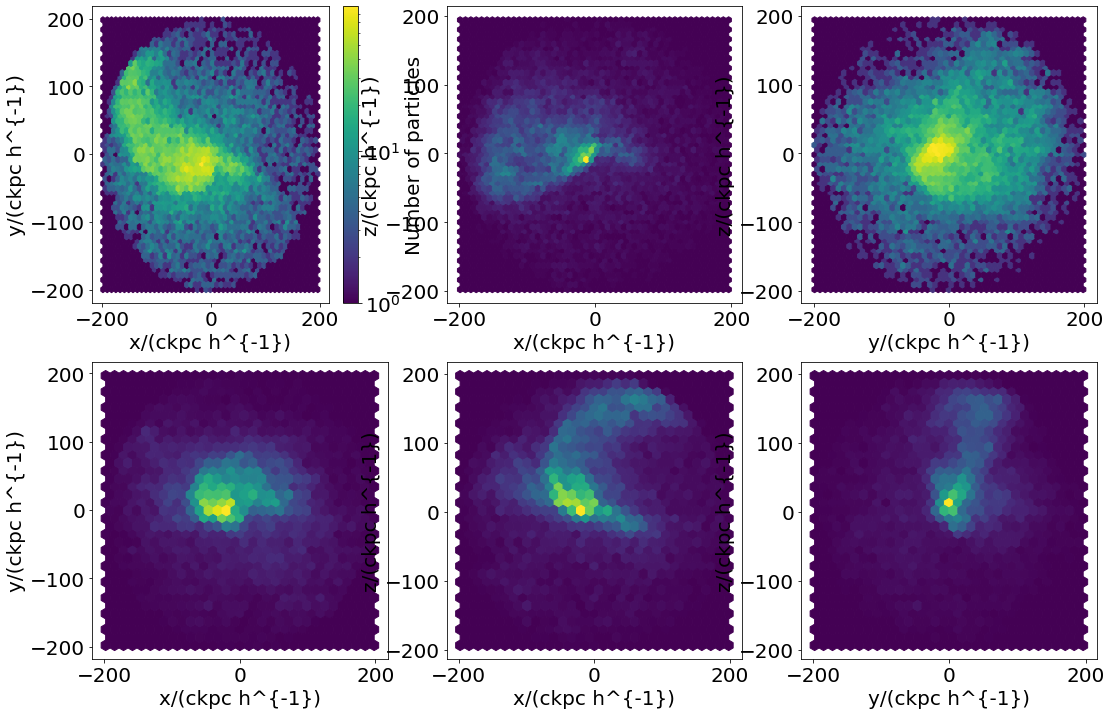

In [14]:
pl.figure(figsize=(18, 12))

pl.subplot(2, 3, 1)

print(XRv.size)

pl.hexbin(XRv, YRv, gridsize=50, bins='log')
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')


pl.subplot(2, 3, 2)

pl.hexbin(XRv, ZRv, gridsize=50)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

pl.subplot(2, 3, 3)

pl.hexbin(YRv, ZRv, gridsize=50, bins='log')
pl.xlabel('y/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

pl.subplot(2, 3, 4)

pl.hexbin(XRc, YRc, gridsize=30)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

pl.subplot(2, 3, 5)

pl.hexbin(XRc, ZRc, gridsize=30)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

pl.subplot(2, 3, 6)

pl.hexbin(YRc, ZRc, gridsize=30)
pl.xlabel('y/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

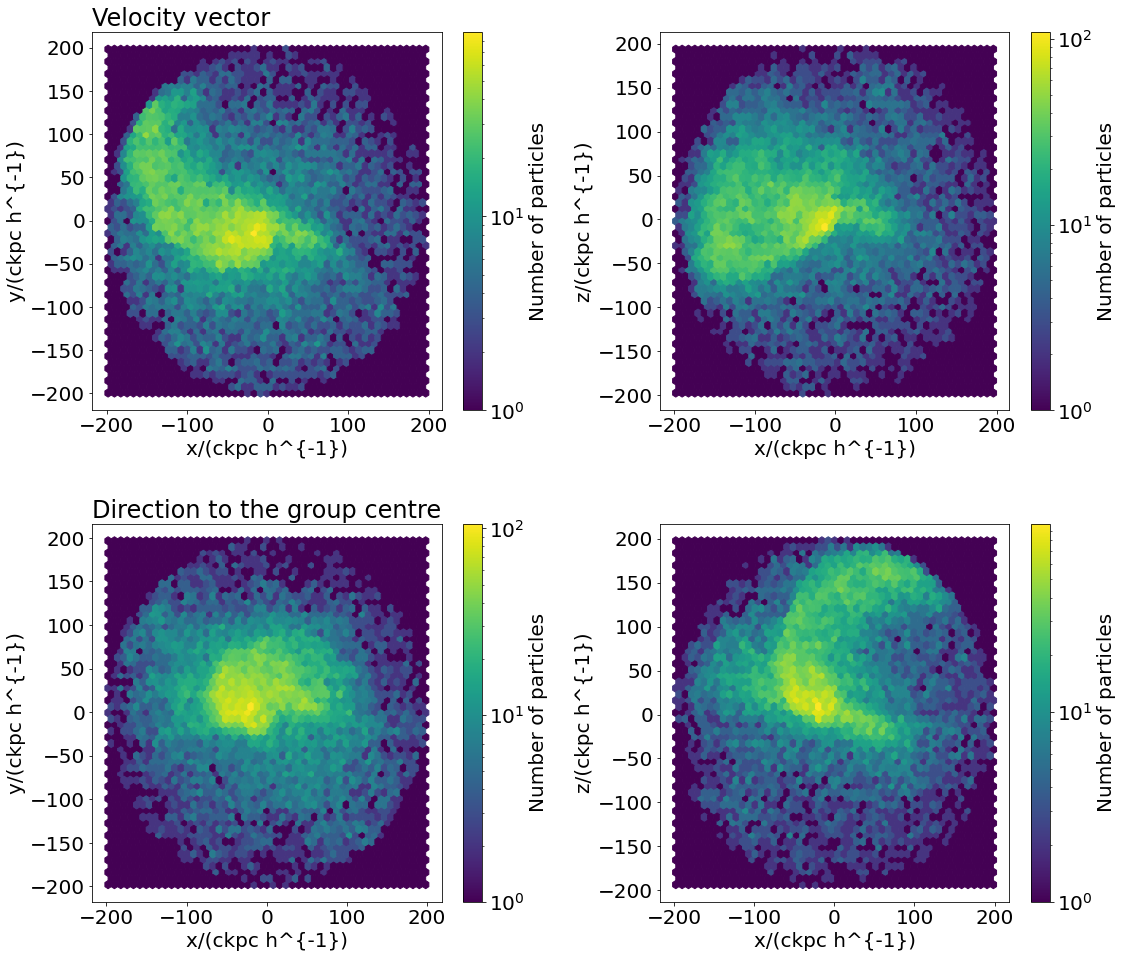

In [15]:
# lest do log, and then linear graphs
pl.figure(figsize=(18, 16))

pl.subplots_adjust(wspace=0.3, hspace=0.3)

pl.subplot(2, 2, 1)

pl.title('Velocity vector', loc='left')

pl.hexbin(XRv, YRv, gridsize=50, bins='log')
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 2)

pl.hexbin(XRv, ZRv, gridsize=50, bins='log')
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 3)

pl.title('Direction to the group centre', loc='left')

pl.hexbin(XRc, YRc, gridsize=50, bins='log')
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 4)

pl.hexbin(XRc, ZRc, gridsize=50, bins='log')
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

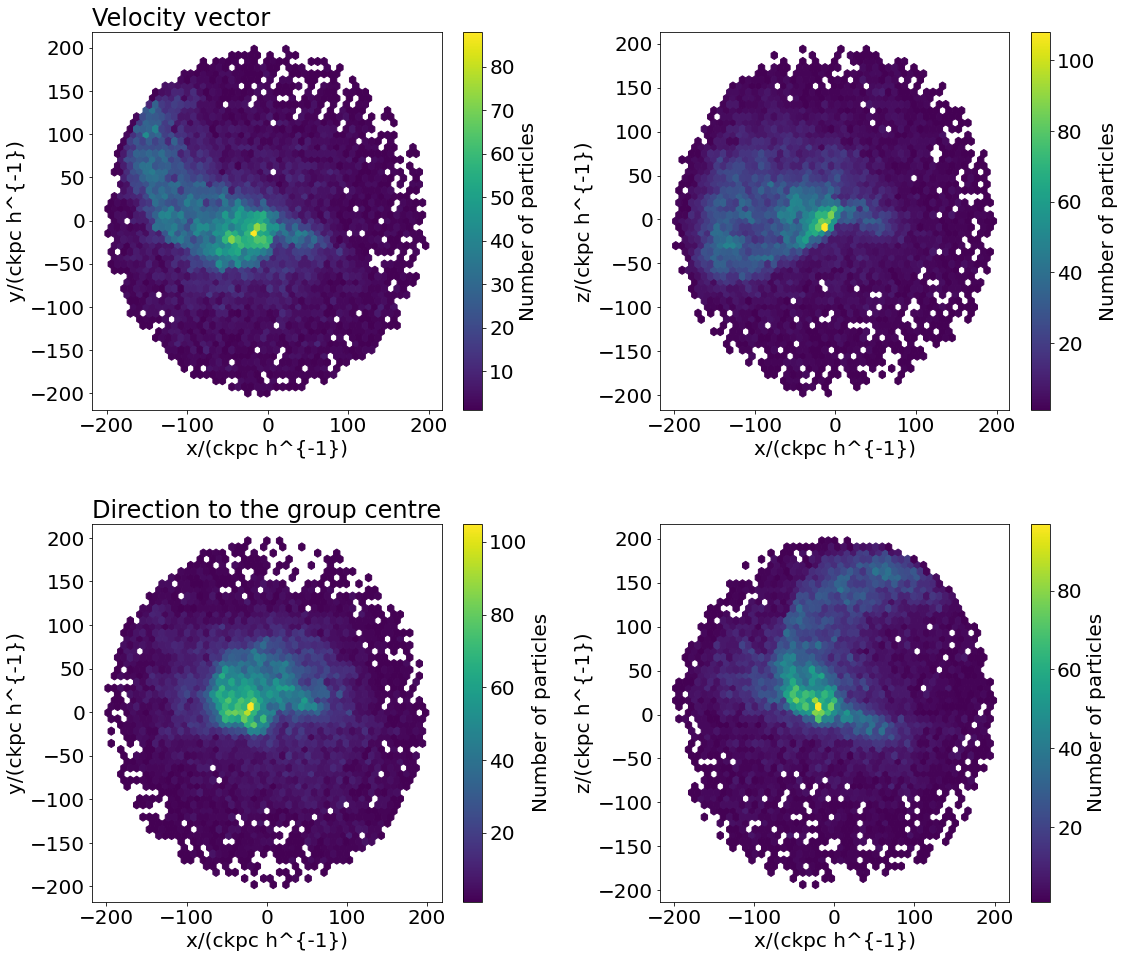

In [16]:
# lest do log, and then linear graphs
pl.figure(figsize=(18, 16))

pl.subplots_adjust(wspace=0.3, hspace=0.3)

pl.subplot(2, 2, 1)

pl.title('Velocity vector',loc='left')

pl.hexbin(XRv, YRv, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 2)

pl.hexbin(XRv, ZRv, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 3)

pl.title('Direction to the group centre', loc='left')

pl.hexbin(XRc, YRc, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 4)

pl.hexbin(XRc, ZRc, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

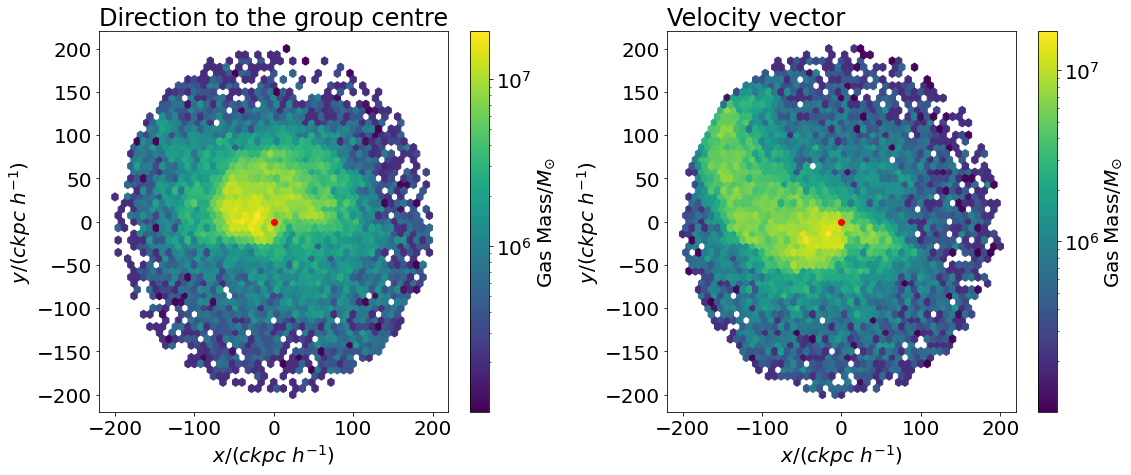

In [17]:
# and now log mass, and log Si, for instance
# pl.figure(figsize=(18, 16))
pl.figure(figsize=(18, 7))

pl.subplots_adjust(wspace=0.3, hspace=0.3)
binn = 'log'

# pl.subplot(2, 2, 1)

pl.subplot(1,2,2)

pl.title('Velocity vector', loc='left')

pl.hexbin(XRv, YRv, C=GASMasses*1e10, gridsize=50, bins=binn, reduce_C_function=np.sum, extent=(-200,200,-200,200))
# pl.xlabel('x/(ckpc h^{-1})')
# pl.ylabel('y/(ckpc h^{-1})')

pl.xlabel('$x/(ckpc\,\,h^{-1})$')
pl.ylabel('$y/(ckpc\,\,h^{-1})$')

pl.plot(0, 0, marker='o', color='red')

bar = pl.colorbar(label='Gas Mass/$M_{\odot}$')

# pl.subplot(2, 2, 2)

# pl.hexbin(XRv, ZRv, C=GASMasses*1e10, gridsize=50, bins=binn, reduce_C_function=np.sum)
# pl.xlabel('x/(ckpc h^{-1})')
# pl.ylabel('z/(ckpc h^{-1})')

# bar = pl.colorbar(label='Gas Mass/(10^{10} M_sun)')

# pl.subplot(2, 2, 3)
pl.subplot(1, 2, 1)

pl.title('Direction to the group centre', loc='left')

pl.hexbin(XRc, YRc, C=GASMasses*1e10, gridsize=50, bins=binn, reduce_C_function=np.sum, extent=(-200,200,-200,200))
# pl.xlabel('x/(ckpc h^{-1})')
# pl.ylabel('y/(ckpc h^{-1})')

pl.xlabel('$x/(ckpc\,\,h^{-1})$')
pl.ylabel('$y/(ckpc\,\,h^{-1})$')

pl.plot(0, 0, marker='o', color='red')

bar = pl.colorbar(label='Gas Mass/$M_{\odot}$')

# pl.subplot(2, 2, 4)

# pl.hexbin(XRc, ZRc, C=GASMasses*1e10, gridsize=50, bins=binn, reduce_C_function=np.sum)
# pl.xlabel('x/(ckpc h^{-1})')
# pl.ylabel('z/(ckpc h^{-1})')

# bar = pl.colorbar(label='Gas Mass/(10^{10} M_sun)')

# pl.savefig('paperGraphs/XY_500.pdf')

In [18]:
sim['SnapNumber_127/PartType0/Abundances'].attrs['description']

'Mass in individual elements: He, C, Mg, O, Fe, Si, H, N, Ne, S, Ca, Zi (in this order)'

In [19]:
GASAbundances.shape

(18755, 12)

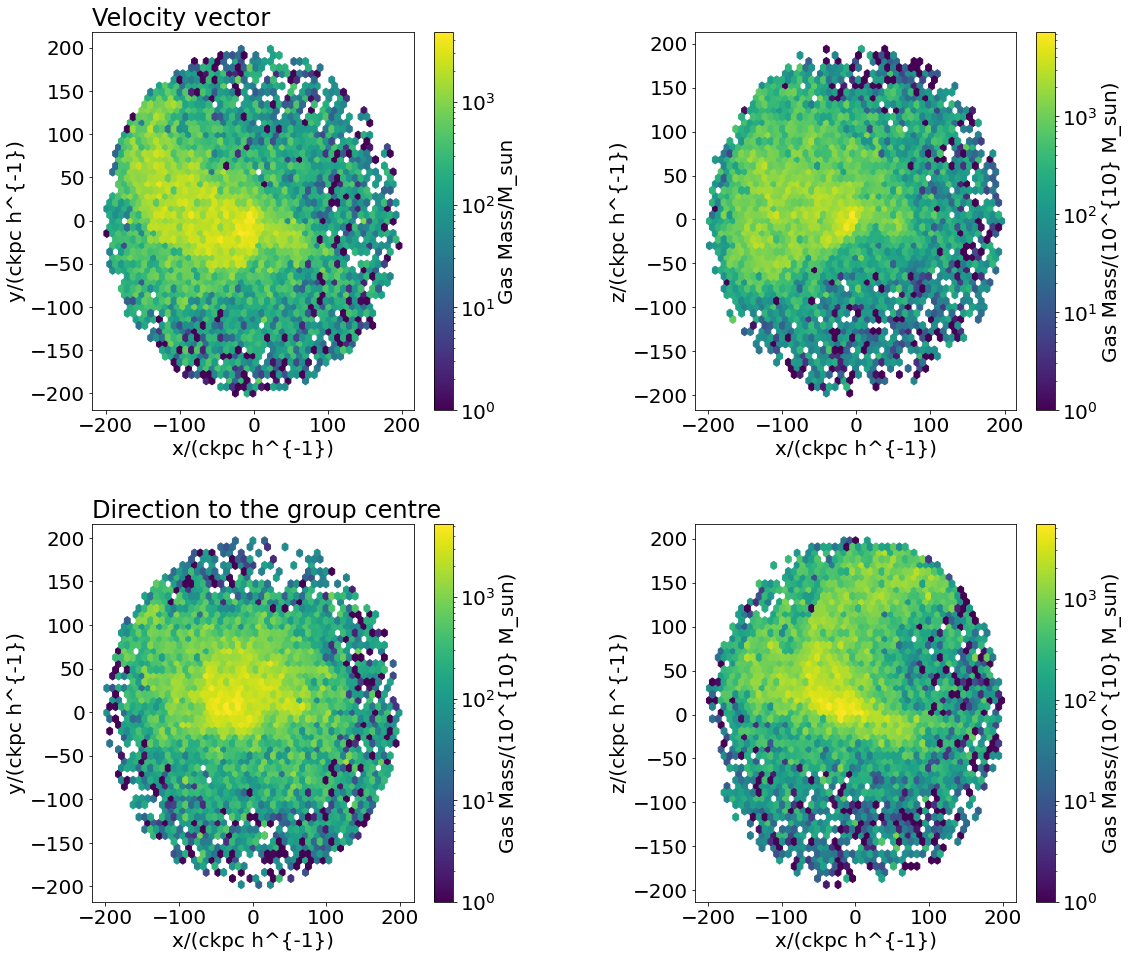

In [20]:
Si = GASAbundances[:,5]

pl.figure(figsize=(18, 16))

pl.subplots_adjust(wspace=0.5, hspace=0.3)
binn = 'log'

pl.subplot(2, 2, 1)

pl.title('Velocity vector', loc='left')

pl.hexbin(XRv, YRv, C=Si*1e10, gridsize=50, bins=binn, reduce_C_function=np.sum)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Gas Mass/M_sun')

pl.subplot(2, 2, 2)

pl.hexbin(XRv, ZRv, C=Si*1e10, gridsize=50, bins=binn, reduce_C_function=np.sum)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Gas Mass/(10^{10} M_sun)')

pl.subplot(2, 2, 3)

pl.title('Direction to the group centre', loc='left')

pl.hexbin(XRc, YRc, C=Si*1e10, gridsize=50, bins=binn, reduce_C_function=np.sum)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Gas Mass/(10^{10} M_sun)')

pl.subplot(2, 2, 4)

pl.hexbin(XRc, ZRc, C=Si*1e10, gridsize=50, bins=binn, reduce_C_function=np.sum)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Gas Mass/(10^{10} M_sun)')

In [21]:
# and now we start with the fun, the list of ids that are not.

In [22]:
def countun(x):
    un = np.unique(x)
    return un.size

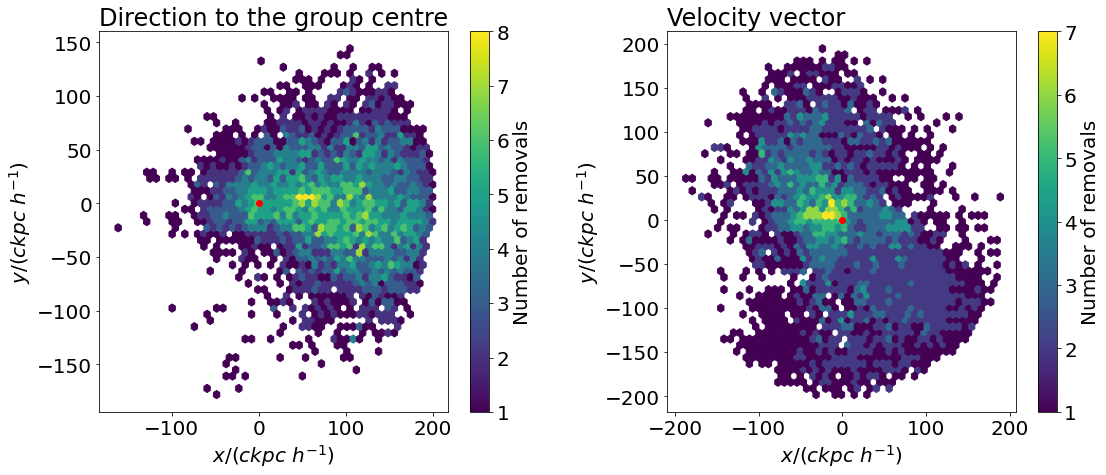

In [23]:
# and now the weird map thing, lets take a look
# pl.figure(figsize=(18, 16))
pl.figure(figsize=(18, 7))

pl.subplots_adjust(wspace=0.3, hspace=0.3)
binn = None

# pl.subplot(2, 2, 1)

pl.subplot(1,2,2)

pl.title('Velocity vector', loc='left')

pl.hexbin(XCv, YCv, C=DATAoff, gridsize=50, bins=binn, reduce_C_function=countun)
# pl.xlabel('x/(ckpc h^{-1})')
# pl.ylabel('y/(ckpc h^{-1})')

pl.plot(0, 0, marker='o', color='red')

pl.xlabel('$x/(ckpc\,\,h^{-1})$')
pl.ylabel('$y/(ckpc\,\,h^{-1})$')

bar = pl.colorbar(label='Number of removals')

pl.subplot(1, 2, 1)

pl.title('Direction to the group centre', loc='left')

pl.hexbin(XCc, YCc, C=DATAoff, gridsize=50, bins=binn, reduce_C_function=countun)
# pl.xlabel('x/(ckpc h^{-1})')
# pl.ylabel('y/(ckpc h^{-1})')

pl.plot(0, 0, marker='o', color='red')

pl.xlabel('$x/(ckpc\,\,h^{-1})$')
pl.ylabel('$y/(ckpc\,\,h^{-1})$')

bar = pl.colorbar(label='Number of removals')

In [24]:
def weigtednum(x):
    un = np.unique(x)
    return (Satellites.size-un.size)/Satellites.size

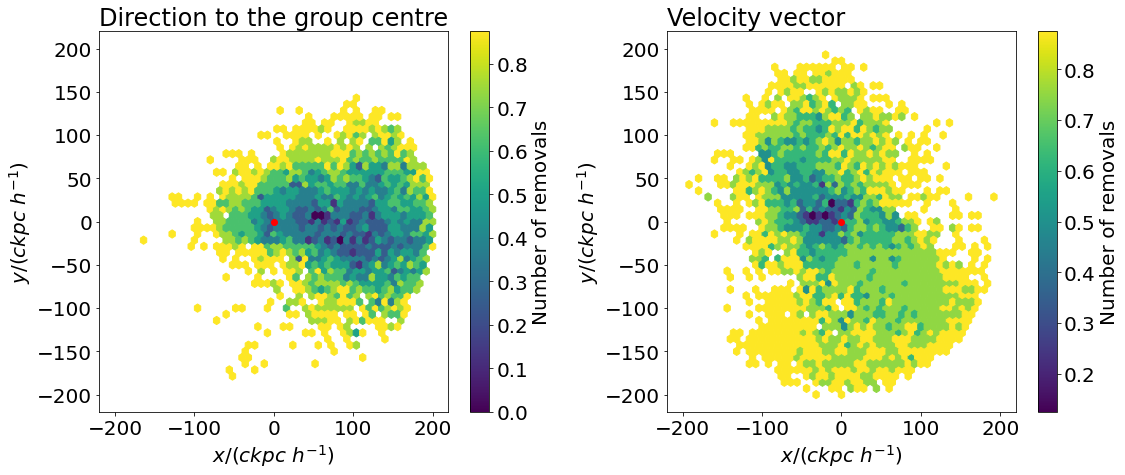

In [25]:
# and now the weird map thing, lets take a look
# pl.figure(figsize=(18, 16))
pl.figure(figsize=(18, 7))

pl.subplots_adjust(wspace=0.3, hspace=0.3)
binn = None

# pl.subplot(2, 2, 1)

pl.subplot(1,2,2)

pl.title('Velocity vector', loc='left')

pl.hexbin(XCv, YCv, C=DATAoff, gridsize=50, bins=binn, reduce_C_function=weigtednum, extent=(-200,200,-200,200))
# pl.xlabel('x/(ckpc h^{-1})')
# pl.ylabel('y/(ckpc h^{-1})')

pl.plot(0, 0, marker='o', color='red')

pl.xlabel('$x/(ckpc\,\,h^{-1})$')
pl.ylabel('$y/(ckpc\,\,h^{-1})$')

bar = pl.colorbar(label='Number of removals')

pl.subplot(1, 2, 1)

pl.title('Direction to the group centre', loc='left')

pl.hexbin(XCc, YCc, C=DATAoff, gridsize=50, bins=binn, reduce_C_function=weigtednum, extent=(-200,200,-200,200))
# pl.xlabel('x/(ckpc h^{-1})')
# pl.ylabel('y/(ckpc h^{-1})')

pl.plot(0, 0, marker='o', color='red')

pl.xlabel('$x/(ckpc\,\,h^{-1})$')
pl.ylabel('$y/(ckpc\,\,h^{-1})$')

bar = pl.colorbar(label='Number of removals')

100% (8 of 8) |##########################| Elapsed Time: 0:03:13 ETA:  00:00:00

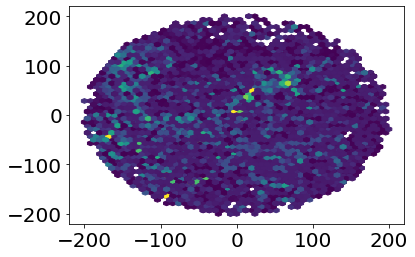

In [26]:
# ok, now with the two options, firts, option 1, all galaxies by their own, then average
Xc, Yc, Xv, Yv = [], [], [], []
Datav, Datac = [], []

size = Satellites.size
# size = 100

bar = progressbar.ProgressBar(max_value=size)
C = 0

for ff, cc in zip(Satellites, Centrals):
    xRv, yRv, zRv, xRc, yRc, zRc, GasMasses, GasAbundances, xCv, yCv, zCv, xCc, yCc, zCc, datoff = getAllLastP(ff, cc)
    PolyC = pl.hexbin(xRc, yRc, C=GasMasses*1e10, gridsize=50, bins=binn, reduce_C_function=np.sum, extent=(-200,200,-200,200))
    PolyV = pl.hexbin(xRv, yRv, C=GasMasses*1e10, gridsize=50, bins=binn, reduce_C_function=np.sum, extent=(-200,200,-200,200))
    
    posC = PolyC.get_offsets()
    posV = PolyV.get_offsets()
    
    xC, yC = posC[:,0], posC[:,1]
    xV, yV = posV[:,0], posV[:,1]
    
    dC = PolyC.get_array()
    dV = PolyV.get_array()
    
    Xc.extend(list(xC))
    Yc.extend(list(yC))
    Xv.extend(list(xV))
    Yv.extend(list(yV))
    
    Datac.extend(list(dC))
    Datav.extend(list(dV))
    
    C += 1
    bar.update(C)
    
Xc, Yc, Xv, Yv = np.array(Xc), np.array(Yc), np.array(Xv), np.array(Yv)
Datav, Datac = np.array(Datav), np.array(Datac)

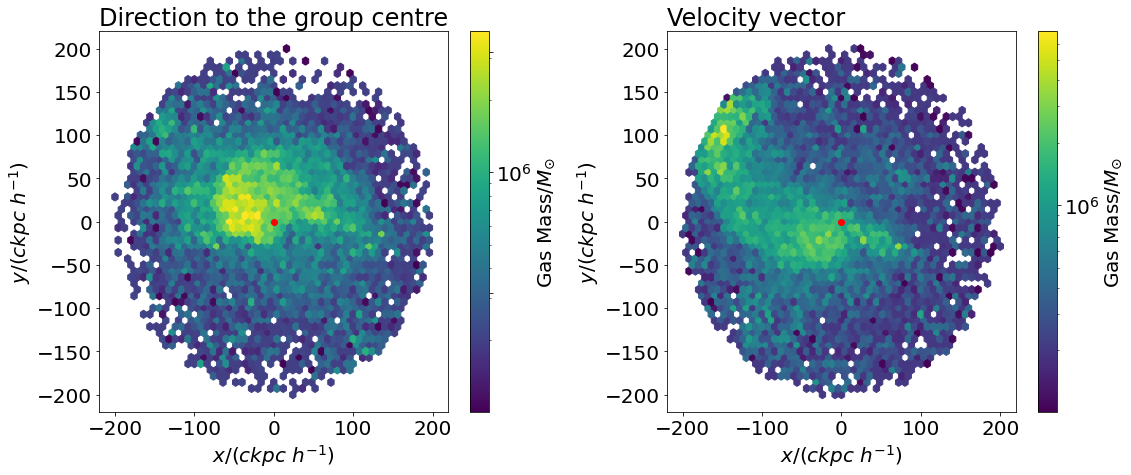

In [27]:
# and now log mass, and log Si, for instance
# pl.figure(figsize=(18, 16))
pl.figure(figsize=(18, 7))

pl.subplots_adjust(wspace=0.3, hspace=0.3)
binn = 'log'

# pl.subplot(2, 2, 1)

pl.subplot(1,2,2)

pl.title('Velocity vector', loc='left')

pl.hexbin(Xv, Yv, C=Datav, gridsize=50, bins=binn, reduce_C_function=np.mean, extent=(-200,200,-200,200))
# pl.xlabel('x/(ckpc h^{-1})')
# pl.ylabel('y/(ckpc h^{-1})')

pl.xlabel('$x/(ckpc\,\,h^{-1})$')
pl.ylabel('$y/(ckpc\,\,h^{-1})$')

pl.plot(0, 0, marker='o', color='red')

bar = pl.colorbar(label='Gas Mass/$M_{\odot}$')

# pl.subplot(2, 2, 2)

# pl.hexbin(XRv, ZRv, C=GASMasses*1e10, gridsize=50, bins=binn, reduce_C_function=np.sum)
# pl.xlabel('x/(ckpc h^{-1})')
# pl.ylabel('z/(ckpc h^{-1})')

# bar = pl.colorbar(label='Gas Mass/(10^{10} M_sun)')

# pl.subplot(2, 2, 3)
pl.subplot(1, 2, 1)

pl.title('Direction to the group centre', loc='left')

pl.hexbin(Xc, Yc, C=Datac, gridsize=50, bins=binn, reduce_C_function=np.mean, extent=(-200,200,-200,200))
# pl.xlabel('x/(ckpc h^{-1})')
# pl.ylabel('y/(ckpc h^{-1})')

pl.xlabel('$x/(ckpc\,\,h^{-1})$')
pl.ylabel('$y/(ckpc\,\,h^{-1})$')

pl.plot(0, 0, marker='o', color='red')

bar = pl.colorbar(label='Gas Mass/$M_{\odot}$')
bar.set_ticks((10**5.5, 10.**6, 10**6.5))

# pl.subplot(2, 2, 4)

# pl.hexbin(XRc, ZRc, C=GASMasses*1e10, gridsize=50, bins=binn, reduce_C_function=np.sum)
# pl.xlabel('x/(ckpc h^{-1})')
# pl.ylabel('z/(ckpc h^{-1})')

# bar = pl.colorbar(label='Gas Mass/(10^{10} M_sun)')

# pl.savefig('paperGraphs/XY_500.pdf')

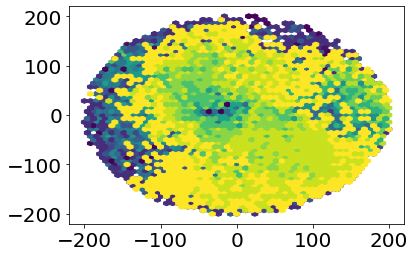

In [28]:
# and now the second one, the multiply thing

PlotV = pl.hexbin(XRv, YRv, C=GASMasses*1e10, gridsize=50, bins=binn, reduce_C_function=np.sum, extent=(-200,200,-200,200))
PlotC = pl.hexbin(XRc, YRc, C=GASMasses*1e10, gridsize=50, bins=binn, reduce_C_function=np.sum, extent=(-200,200,-200,200))

posC = PlotC.get_offsets()
posV = PlotV.get_offsets()
    
xC, yC = posC[:,0], posC[:,1]
xV, yV = posV[:,0], posV[:,1]
    
dC = PlotC.get_array()
dV = PlotV.get_array()

PlotCC = pl.hexbin(XCc, YCc, C=DATAoff, gridsize=50, bins=binn, reduce_C_function=weigtednum, extent=(-200,200,-200,200))
PlotCV = pl.hexbin(XCv, YCv, C=DATAoff, gridsize=50, bins=binn, reduce_C_function=weigtednum, extent=(-200,200,-200,200))

posCC = PlotCC.get_offsets()
posCV = PlotCV.get_offsets()
    
xCC, yCC = posCC[:,0], posCC[:,1]
xCV, yCV = posCV[:,0], posCV[:,1]
    
dCC = PlotCC.get_array()
dCV = PlotCV.get_array()

I = np.arange(xC.size)

for i, xx, yy in zip(I, xC, yC):
    ik = np.where((xCC==xx) & (yCC==yy))[0]
    if ik.size==1:
        dC[i] = dC[i]/dCC[ik[0]]
    elif ik.size>1:
        print('c: weird')
        
J = np.arange(xV.size)

for j, xx, yy in zip(J, xV, yV):
    ik = np.where((xCV==xx) & (yCV==yy))[0]
    if ik.size==1:
        dV[j] = dV[j]/dCV[ik[0]]
    elif ik.size>1:
        print('v: weird')
        

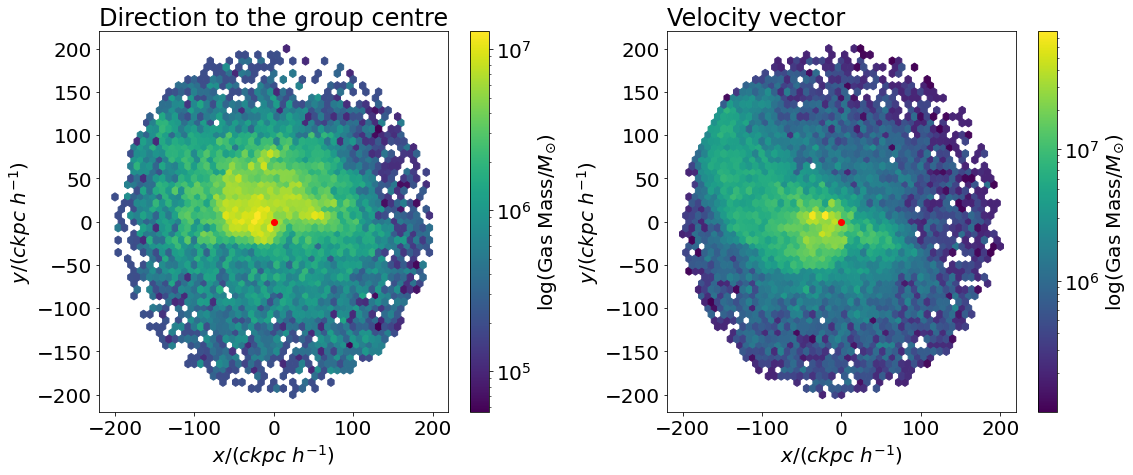

In [29]:
# and now log mass, and log Si, for instance
# pl.figure(figsize=(18, 16))
pl.figure(figsize=(18, 7))

pl.subplots_adjust(wspace=0.3, hspace=0.3)
binn = 'log'

# pl.subplot(2, 2, 1)

pl.subplot(1,2,2)

pl.title('Velocity vector', loc='left')

pl.hexbin(xV, yV, C=dV, gridsize=50, bins=binn, reduce_C_function=np.mean, extent=(-200,200,-200,200))
# pl.xlabel('x/(ckpc h^{-1})')
# pl.ylabel('y/(ckpc h^{-1})')

pl.xlabel('$x/(ckpc\,\,h^{-1})$')
pl.ylabel('$y/(ckpc\,\,h^{-1})$')

pl.plot(0, 0, marker='o', color='red')

bar = pl.colorbar(label='$\log$(Gas Mass/$M_{\odot}$)')

# pl.subplot(2, 2, 2)

# pl.hexbin(XRv, ZRv, C=GASMasses*1e10, gridsize=50, bins=binn, reduce_C_function=np.sum)
# pl.xlabel('x/(ckpc h^{-1})')
# pl.ylabel('z/(ckpc h^{-1})')

# bar = pl.colorbar(label='Gas Mass/(10^{10} M_sun)')

# pl.subplot(2, 2, 3)
pl.subplot(1, 2, 1)

pl.title('Direction to the group centre', loc='left')

pl.hexbin(xC, yC, C=dC, gridsize=50, bins=binn, reduce_C_function=np.mean, extent=(-200,200,-200,200))
# pl.xlabel('x/(ckpc h^{-1})')
# pl.ylabel('y/(ckpc h^{-1})')

pl.xlabel('$x/(ckpc\,\,h^{-1})$')
pl.ylabel('$y/(ckpc\,\,h^{-1})$')

pl.plot(0, 0, marker='o', color='red')

bar = pl.colorbar(label='$\log$(Gas Mass/$M_{\odot})$')

# pl.subplot(2, 2, 4)

# pl.hexbin(XRc, ZRc, C=GASMasses*1e10, gridsize=50, bins=binn, reduce_C_function=np.sum)
# pl.xlabel('x/(ckpc h^{-1})')
# pl.ylabel('z/(ckpc h^{-1})')

# bar = pl.colorbar(label='Gas Mass/(10^{10} M_sun)')

# pl.savefig('paperGraphs/XY_500.pdf')

In [30]:
# and now some Monte Carlo integration

def getMonte(fofID, centralID):
    """
    get monte carlo approximation to the lost area
    """
    uniqueID = int(128*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    #firts find all the particleIDs that once belong to the subgroup
    Idlist = []
    
    I = np.identity(3)
    
    for mm in mtree[1:]: # ignore the first one
        snap, idd = split_unique_id(int(mm))
        tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        if tempOff[0]>= 0 and tempOff[1]>=0:
            tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
#             # and the temperature
            Idlist.extend(list(tempIds))

    Idlist = np.array(Idlist)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][fofID].astype('int')
    
    IndexToday = np.in1d(TdayTotalIDs, Idlist)
    IndexToday_ = np.where(IndexToday)[0]
    
    # lets remove the ones that are not part of the group today.
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    #now lets cut at  a certain distance
    #distance = 600 # distance in ckpc
    distance = 200
    
    posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][centralID]

    LostCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_]
    
    dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
    distToC = np.sqrt(dx**2+dy**2+dz**2)

    icut = np.where(distToC<distance)[0]
    IndexT_near = IndexT_[icut] # this is the almost final list of particles ids, but not yet
    
    LostNow = sim['SnapNumber_128/PartType0/SubGroupNumber'][IndexT_near]
    
    icut3 = np.where(LostNow==0)[0]
    IndexT_near_cutted = IndexT_near[icut3]
      
    npart = 10000
    distance = 200.
    
    
    # the mdistance is gonna be according to the distance to the last particle that belong to teh central galaxy
#     offcen = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][centralID].astype('int')
    
#     poscen = sim['SnapNumber_128/PartType0/Coordinates'][offcen[0]:offcen[1]]

#     xx, yy, zz = poscen[:,0] - posCen[0], poscen[:,1] - posCen[1], poscen[:,2] - posCen[2]
    
#     cdist = np.sqrt(xx**2+yy**2+zz**2.)
#     mdistance = cdist.max()
    
    LostCoord_cutted = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_near_cutted]
    
    xx, yy, zz = LostCoord_cutted[:,0] - posCen[0], LostCoord_cutted[:,1] - posCen[1], LostCoord_cutted[:,2] - posCen[2]
    cdist = np.sqrt(xx**2+yy**2+zz**2.)
    mdistance = np.percentile(cdist, 99)
    
    dx, dy, dz = np.random.random(size=npart)*400-200., np.random.random(size=npart)*400-200., np.random.random(size=npart)*400-200.
    distToC = np.sqrt(dx**2+dy**2+dz**2)

    icut = np.where(distToC<distance)[0]
    nfin = icut.size
    dx, dy, dz = dx[icut], dy[icut], dz[icut]
    
    dx2, dy2, dz2 = dx+posGal[0]-posCen[0], dy+posGal[1]-posCen[1], dz+posGal[2]-posCen[2]
    distToC2 = np.sqrt(dx2**2+dy2**2+dz2**2)

    icut3 = np.where(distToC2<mdistance)[0]
    
    # ok, lest see velocity and stuff
    velCen = sim['SnapNumber_128/SubGroups/SubGroupVel'][centralID]
    velSat = sim['SnapNumber_128/SubGroups/SubGroupVel'][fofID]

    velRep = velSat - velCen
 
    X, Y, Z = dx, dy, dz
    XC, YC, ZC = dx[icut3], dy[icut3], dz[icut3]
    xC, yC, zC = posCen[0] - posGal[0], posCen[1] - posGal[1], posCen[2] - posGal[2]
    
    # now define normalized vectors, for velocity and centre directions
    velX, velY, velZ = velRep[0], velRep[1], velRep[2]
    Vel = np.sqrt(velX**2 + velY**2 + velZ**2)
    Cen = np.sqrt(xC**2 + yC**2 + zC**2)

    velx, vely, velz = velX/Vel, velY/Vel, velZ/Vel
    xc, yc, zc = xC/Cen, yC/Cen, zC/Cen
    
    # Then, the rotations matrix are, for velocity
    faV = (1-velx)/(vely**2 + velz**2)
    VV = np.array([[0, vely, velz], [-vely, 0, 0], [-velz, 0, 0]])
    VV2 = np.matmul(VV, VV)

    RV = I + VV + VV2*faV
    
    # and for the direction to the centre
    faC = (1-xc)/(yc**2+zc**2)
    CC = np.array([[0, yc, zc], [-yc, 0, 0], [-zc, 0, 0]])
    CC2 = np.matmul(CC, CC)

    RC = I + CC + CC2*faC
    
    # lets calculate the rotated coordinates
    xRv, yRv, zRv = [], [], []
    xRc, yRc, zRc = [], [], []

    for x, y, z in zip(X, Y, Z):
        dV = np.matmul(RV, np.array([x, y, z]))
        dC = np.matmul(RC, np.array([x, y, z]))
    
        xRv.append(dV[0])
        yRv.append(dV[1])
        zRv.append(dV[2])
    
        xRc.append(dC[0])
        yRc.append(dC[1])
        zRc.append(dC[2])
    
    xRv, yRv, zRv = np.array(xRv), np.array(yRv), np.array(zRv)
    xRc, yRc, zRc = np.array(xRc), np.array(yRc), np.array(zRc)
    
    xCv, yCv, zCv = [], [], []
    xCc, yCc, zCc = [], [], []
    
    for x, y, z in zip(XC, YC, ZC):
        dV = np.matmul(RV, np.array([x, y, z]))
        dC = np.matmul(RC, np.array([x, y, z]))
    
        xCv.append(dV[0])
        yCv.append(dV[1])
        zCv.append(dV[2])
    
        xCc.append(dC[0])
        yCc.append(dC[1])
        zCc.append(dC[2])
        
    xCv, yCv, zCv = np.array(xCv), np.array(yCv), np.array(zCv)
    xCc, yCc, zCc = np.array(xCc), np.array(yCc), np.array(zCc)
    
#     # now, I only need one number, the cos stuff
#     cosC = xRc/np.sqrt(xRc**2.+yRc**2.+zRc**2.)
#     cosV = xRv/np.sqrt(xRv**2.+yRv**2.+zRv**2.)
    
#     cosCC = xCc/np.sqrt(xCc**2.+yCc**2.+zCc**2.)
#     cosCV = xCv/np.sqrt(xCv**2.+yCv**2.+zCv**2.)
    
#     # and return the 2 sets of rotated positions, masses and abundances
#     return cosV, cosC, cosCV, cosCC

    return xRv, yRv, zRv, xRv, yRv, zRv, xCv, yCv, zCv, xCc, yCc, zCc

In [31]:
size = Satellites.size
# size = 100

bar = progressbar.ProgressBar(max_value=size)
C, passs = 0, 0

XRV, YRV, ZRV, XRC, YRC, ZRC = [], [], [], [], [], []
XCV, YCV, ZCV, XCC, YCC, ZCC = [], [], [], [], [], []

for ff, cc in zip(Satellites, Centrals):
#     try:
    xRv, yRv, zRv, xRc, yRc, zRc, xCv, yCv, zCv, xCc, yCc, zCc = getMonte(ff, cc)
    passs += 1
#     except:
#         C += 1
#         continue
    XRV.extend(list(xRv))
    YRV.extend(list(yRv))
    ZRV.extend(list(zRv))
    XRC.extend(list(xRc))
    YRC.extend(list(yRc))
    ZRC.extend(list(zRc))
    
    XCV.extend(list(xCv))
    YCV.extend(list(yCv))
    ZCV.extend(list(zCv))
    XCC.extend(list(xCc))
    YCC.extend(list(yCc))
    ZCC.extend(list(zCc))
    
    C += 1
    bar.update(C)
    
XRV, YRV, ZRV, XRC, YRC, ZRC = np.array(XRV), np.array(YRV), np.array(ZRV), np.array(XRC), np.array(YRC), np.array(ZRC)
XCV, YCV, ZCV, XCC, YCC, ZCC = np.array(XCV), np.array(YCV), np.array(ZCV), np.array(XCC), np.array(YCC), np.array(ZCC)
passs

100% (8 of 8) |##########################| Elapsed Time: 0:03:06 ETA:  00:00:00

8

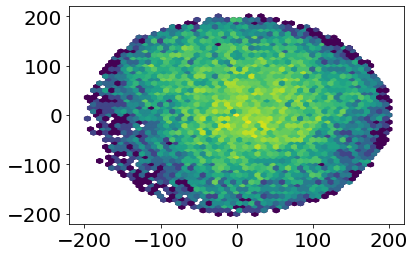

In [32]:
# and now the second one, the multiply thing

PlotV = pl.hexbin(XRV, YRV, C=np.ones(XRV.size), gridsize=50, bins=binn, reduce_C_function=np.sum, extent=(-200,200,-200,200))
PlotC = pl.hexbin(XRC, YRC, C=np.ones(XRC.size), gridsize=50, bins=binn, reduce_C_function=np.sum, extent=(-200,200,-200,200))

posC = PlotC.get_offsets()
posV = PlotV.get_offsets()
    
xC, yC = posC[:,0], posC[:,1]
xV, yV = posV[:,0], posV[:,1]
    
dC = PlotC.get_array()
dV = PlotV.get_array()

PlotCC = pl.hexbin(XCC, YCC, C=np.ones(XCC.size), gridsize=50, bins=binn, reduce_C_function=np.sum, extent=(-200,200,-200,200))
PlotCV = pl.hexbin(XCV, YCV, C=np.ones(XCV.size), gridsize=50, bins=binn, reduce_C_function=np.sum, extent=(-200,200,-200,200))

posCC = PlotCC.get_offsets()
posCV = PlotCV.get_offsets()
    
xCC, yCC = posCC[:,0], posCC[:,1]
xCV, yCV = posCV[:,0], posCV[:,1]
    
dCC = PlotCC.get_array()
dCV = PlotCV.get_array()

II = np.arange(xC.size)

for i, xx, yy in zip(II, xC, yC):
    ik = np.where((xCC==xx) & (yCC==yy))[0]
    if ik.size==1:
        dC[i] = dCC[ik[0]]/(dCC[ik[0]]+dC[i])
    elif ik.size==0:
        dC[i] = 0.
    
xC, yC, dC = list(xC), list(yC), list(dC)

for xx, yy in zip(xCC, yCC):
    ik = np.where((xC==xx) & (yC==yy))[0]
    if ik.size == 0:
        dC.append(1.)
        xC.append(xx)
        yC.append(yy)

xC, yC, dC = np.array(xC), np.array(yC), np.array(dC)        
        
J = np.arange(xV.size)

for j, xx, yy in zip(J, xV, yV):
    ik = np.where((xCV==xx) & (yCV==yy))[0]
    if ik.size==1:
        dV[j] = dCV[ik[0]]/(dCV[ik[0]]+dV[j])
    elif ik.size==0:
        dV[j] = 0.
        
xV, yV, dV = list(xV), list(yV), list(dV)

for xx, yy in zip(xCV, yCV):
    ik = np.where((xV==xx) & (yV==yy))[0]
    if ik.size == 0:
        dV.append(1.)
        xV.append(xx)
        yV.append(yy)
        
xV, yV, dV = np.array(xV), np.array(yV), np.array(dV)

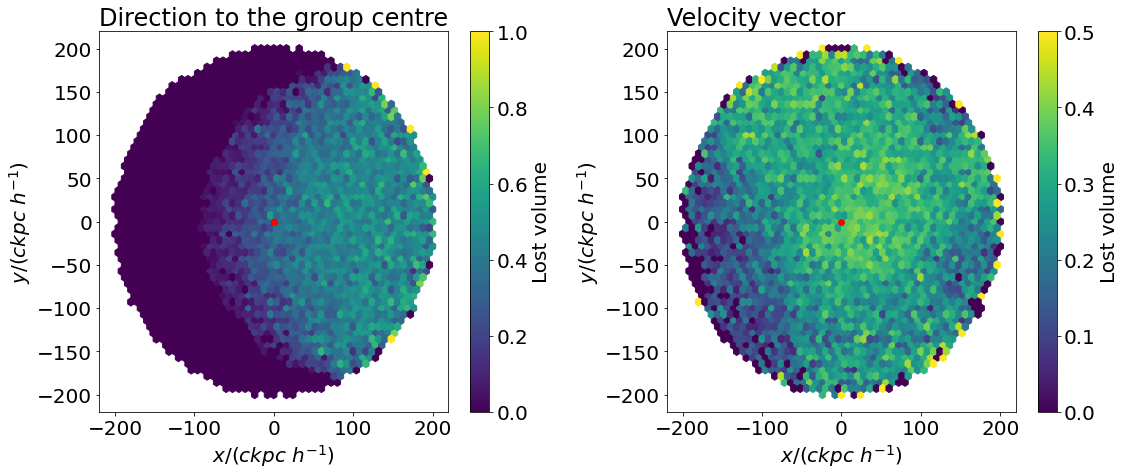

In [33]:
# and now log mass, and log Si, for instance
# pl.figure(figsize=(18, 16))
pl.figure(figsize=(18, 7))

pl.subplots_adjust(wspace=0.3, hspace=0.3)
binn = None

# pl.subplot(2, 2, 1)

pl.subplot(1,2,2)

pl.title('Velocity vector', loc='left')

pl.hexbin(xV, yV, C=dV, gridsize=50, bins=binn, reduce_C_function=np.mean, extent=(-200,200,-200,200))
# pl.xlabel('x/(ckpc h^{-1})')
# pl.ylabel('y/(ckpc h^{-1})')

pl.xlabel('$x/(ckpc\,\,h^{-1})$')
pl.ylabel('$y/(ckpc\,\,h^{-1})$')

pl.plot(0, 0, marker='o', color='red')

bar = pl.colorbar(label='Lost volume')

# pl.subplot(2, 2, 2)

# pl.hexbin(XRv, ZRv, C=GASMasses*1e10, gridsize=50, bins=binn, reduce_C_function=np.sum)
# pl.xlabel('x/(ckpc h^{-1})')
# pl.ylabel('z/(ckpc h^{-1})')

# bar = pl.colorbar(label='Gas Mass/(10^{10} M_sun)')

# pl.subplot(2, 2, 3)
pl.subplot(1, 2, 1)

pl.title('Direction to the group centre', loc='left')

pl.hexbin(xC, yC, C=dC, gridsize=50, bins=binn, reduce_C_function=np.mean, extent=(-200,200,-200,200))
# pl.xlabel('x/(ckpc h^{-1})')
# pl.ylabel('y/(ckpc h^{-1})')

pl.xlabel('$x/(ckpc\,\,h^{-1})$')
pl.ylabel('$y/(ckpc\,\,h^{-1})$')

pl.plot(0, 0, marker='o', color='red')

bar = pl.colorbar(label='Lost volume')

# pl.subplot(2, 2, 4)

# pl.hexbin(XRc, ZRc, C=GASMasses*1e10, gridsize=50, bins=binn, reduce_C_function=np.sum)
# pl.xlabel('x/(ckpc h^{-1})')
# pl.ylabel('z/(ckpc h^{-1})')

# bar = pl.colorbar(label='Gas Mass/(10^{10} M_sun)')

# pl.savefig('paperGraphs/XY_500.pdf')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars


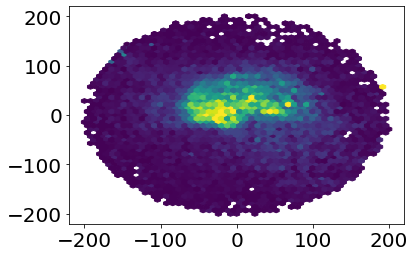

In [34]:
# and now the second one, the multiply thing

xCC, yCC, dCC = xC, yC, dC
xCV, yCV, dCV = xV, yV, dV

PlotV = pl.hexbin(XRv, YRv, C=GASMasses*1e10, gridsize=50, bins=binn, reduce_C_function=np.sum, extent=(-200,200,-200,200))
PlotC = pl.hexbin(XRc, YRc, C=GASMasses*1e10, gridsize=50, bins=binn, reduce_C_function=np.sum, extent=(-200,200,-200,200))

posC = PlotC.get_offsets()
posV = PlotV.get_offsets()
    
xC, yC = posC[:,0], posC[:,1]
xV, yV = posV[:,0], posV[:,1]
    
dC = PlotC.get_array()
dV = PlotV.get_array()

I = np.arange(xC.size)

for i, xx, yy in zip(I, xC, yC):
    ik = np.where((xCC==xx) & (yCC==yy))[0]
    if ik.size==1:
        dC[i] = dC[i]/(1.-dCC[ik[0]])
    elif ik.size>1:
        print('c: weird')
        
J = np.arange(xV.size)

for j, xx, yy in zip(J, xV, yV):
    ik = np.where((xCV==xx) & (yCV==yy))[0]
    if ik.size==1:
        dV[j] = dV[j]/(1.-dCV[ik[0]])
    elif ik.size>1:
        print('v: weird')

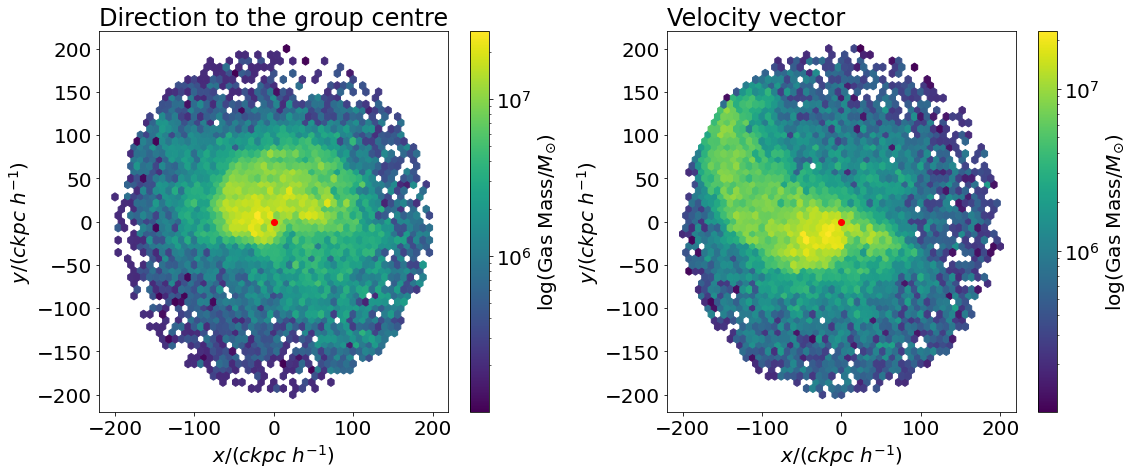

In [35]:
# and now log mass, and log Si, for instance
# pl.figure(figsize=(18, 16))
pl.figure(figsize=(18, 7))

pl.subplots_adjust(wspace=0.3, hspace=0.3)
binn = 'log'

# pl.subplot(2, 2, 1)

pl.subplot(1,2,2)

pl.title('Velocity vector', loc='left')

pl.hexbin(xV, yV, C=dV, gridsize=50, bins=binn, reduce_C_function=np.mean, extent=(-200,200,-200,200))
# pl.xlabel('x/(ckpc h^{-1})')
# pl.ylabel('y/(ckpc h^{-1})')

pl.xlabel('$x/(ckpc\,\,h^{-1})$')
pl.ylabel('$y/(ckpc\,\,h^{-1})$')

pl.plot(0, 0, marker='o', color='red')

bar = pl.colorbar(label='$\log$(Gas Mass/$M_{\odot}$)')

# pl.subplot(2, 2, 2)

# pl.hexbin(XRv, ZRv, C=GASMasses*1e10, gridsize=50, bins=binn, reduce_C_function=np.sum)
# pl.xlabel('x/(ckpc h^{-1})')
# pl.ylabel('z/(ckpc h^{-1})')

# bar = pl.colorbar(label='Gas Mass/(10^{10} M_sun)')

# pl.subplot(2, 2, 3)
pl.subplot(1, 2, 1)

pl.title('Direction to the group centre', loc='left')

pl.hexbin(xC, yC, C=dC, gridsize=50, bins=binn, reduce_C_function=np.mean, extent=(-200,200,-200,200))
# pl.xlabel('x/(ckpc h^{-1})')
# pl.ylabel('y/(ckpc h^{-1})')

pl.xlabel('$x/(ckpc\,\,h^{-1})$')
pl.ylabel('$y/(ckpc\,\,h^{-1})$')

pl.plot(0, 0, marker='o', color='red')

bar = pl.colorbar(label='$\log$(Gas Mass/$M_{\odot})$')

# pl.subplot(2, 2, 4)

# pl.hexbin(XRc, ZRc, C=GASMasses*1e10, gridsize=50, bins=binn, reduce_C_function=np.sum)
# pl.xlabel('x/(ckpc h^{-1})')
# pl.ylabel('z/(ckpc h^{-1})')

# bar = pl.colorbar(label='Gas Mass/(10^{10} M_sun)')

# pl.savefig('paperGraphs/XY_500.pdf')